# 1. Análisis exploratorio de sismos

**Objetivo:** Exploración del dataset

Esta base de de datos es una colección de más de 23,000 sismos en USA. Contiene datos desde 1638 a 1985. La base de datos incluye información correspondiente a las coordenadas del epicentro, magnitudes, profundidad focal, nombres y coordenadas de ciudades reportadas, intensidades reportadas y la distancia de la ciudad al epicentro.


https://www.kaggle.com/srijya/us-earthquake-intensity-database

**Información de las características**
* 0 Year Mo Da Hr Mn Sec
* 1 UTC Conv
* 2 U/G Unpublished or grouped intensity
* 3 EQ Lat 
* 4 EQ Long
* 5 Magnitude
* 6 Depth (km)
* 7 Epi Dis Distancia epicentral
* 8 City Lat
* 9 City Long
* 10 MMI
* 11 State Code
* 12 City Name
* 13 Data Source

**Número de instancias:** 157015

**Número de atributos:** 20



# 2. Acceso a Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 3. Importando librerías

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import plotly.io as pio
from sklearn.neighbors import LocalOutlierFactor

# 4. Lectura del archivo de datos

In [3]:
path = r'/content/drive/Shareddrives/Data Science para Geociencias/2. Preparación de los datos'
name = 'eqint_tsqp.xlsx'

In [4]:
sis_path = os.path.join(path,name)
sismosdf = pd.read_excel(sis_path)
sismosdf.head()

,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,LOCAL_TO_UTC,UNPUB_OR_GROUPED_INT,LATITUDE,LONGITUDE,MAGNITUDE,EQ_DEPTH,EPIDIST,CITY_LAT,CITY_LON,MMI,STATE,CITY,SOURCE,COUNTRY
0,1852,11.0,27.0,NaN,NaN,NaN,8.0,NaN,34.5,-119.0,NaN,NaN,0.0,34.50,-119.00,7.0,CA,LOCKWOOD VALLEY,H,USA
1,1852,11.0,27.0,NaN,NaN,NaN,8.0,NaN,34.5,-119.0,NaN,NaN,258.0,33.02,-116.84,6.0,CA,SAN DIEGO,H,USA
2,1852,11.0,27.0,NaN,NaN,NaN,8.0,NaN,34.5,-119.0,NaN,NaN,159.0,35.35,-120.41,6.0,CA,SAN LUIS OBISPO,H,USA
3,1852,11.0,27.0,NaN,NaN,NaN,8.0,NaN,34.5,-119.0,NaN,NaN,NaN,NaN,NaN,6.0,CA,COLORADO RIVER,H,USA
4,1860,11.0,12.0,NaN,NaN,NaN,8.0,NaN,41.0,-124.0,NaN,NaN,32.0,40.76,-124.22,8.0,CA,HUMBOLDT BAY,H,USA


In [5]:
sismosdf.shape

(157015, 20)

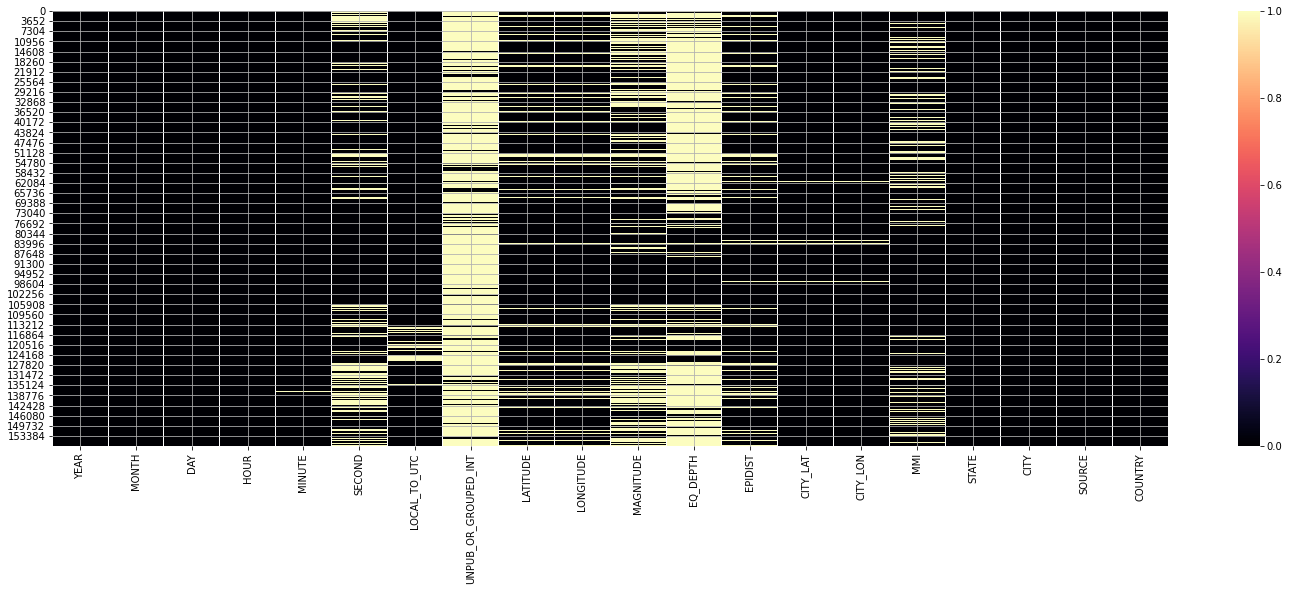

In [6]:
fig, ax = plt.subplots(figsize=(25,8))
sns.heatmap(sismosdf.isnull(), ax=ax, cmap="magma")
plt.grid()
plt.show()

# 5. Limpieza de datos

In [7]:
sismosdf.drop(['UNPUB_OR_GROUPED_INT','LATITUDE','LONGITUDE','EQ_DEPTH', 'LOCAL_TO_UTC'], axis=1, inplace=True)

In [8]:
sismosdf['SECOND'].fillna(0, inplace=True)
sismosdf['MINUTE'].fillna(sismosdf['MINUTE'].mode(), inplace=True)
sismosdf['HOUR'].fillna(sismosdf['HOUR'].mode(), inplace=True)
sismosdf['EPIDIST'].fillna(sismosdf['EPIDIST'].mean(), inplace=True)

In [9]:
sismosdf = sismosdf[sismosdf.MMI.notnull()]
sismosdf = sismosdf[sismosdf.YEAR.notnull()]
sismosdf = sismosdf[sismosdf.MONTH.notnull()]
sismosdf = sismosdf[sismosdf.DAY.notnull()]
sismosdf = sismosdf[sismosdf.CITY_LAT.notnull()]
sismosdf = sismosdf[sismosdf.CITY_LON.notnull()]
sismosdf = sismosdf[sismosdf.MAGNITUDE.notnull()]

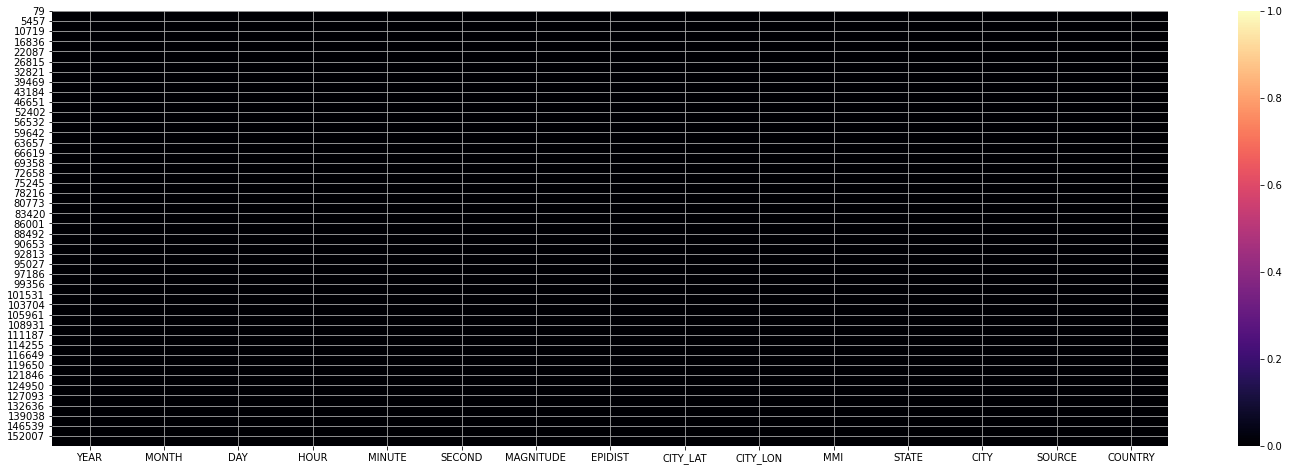

In [10]:
fig, ax = plt.subplots(figsize=(25,8))
sns.heatmap(sismosdf.isnull(), ax=ax, cmap="magma")
plt.grid()
plt.show()

In [11]:
sismosdf.shape

(89617, 15)

# 6. Exploración de los datos

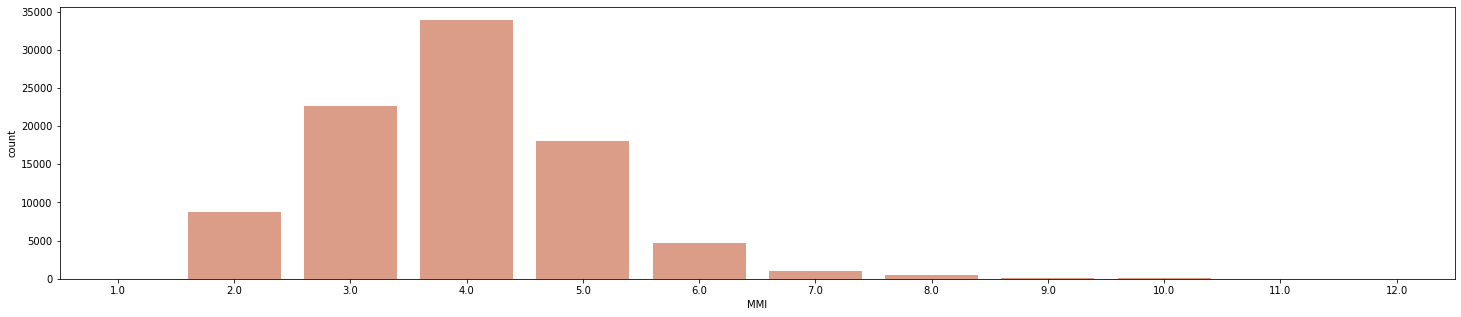

In [12]:
fig, ax = plt.subplots(figsize=(25,5))
sns.countplot(ax=ax, x=sismosdf['MMI'], color='darksalmon')
plt.show()

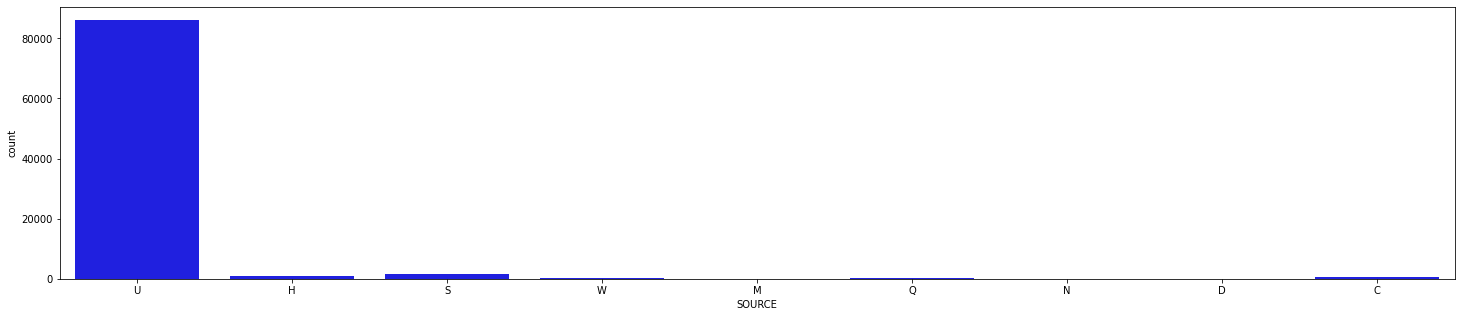

In [13]:
fig, ax = plt.subplots(figsize=(25,5))
sns.countplot(ax=ax, x=sismosdf['SOURCE'], color='blue')
plt.show()

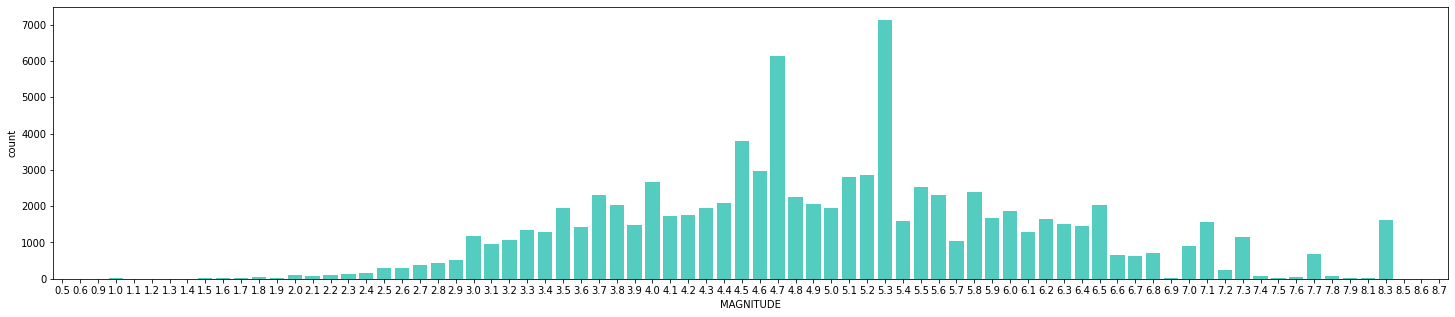

In [14]:
fig, ax = plt.subplots(figsize=(25,5))
sns.countplot(ax=ax, x=sismosdf['MAGNITUDE'], color='turquoise')
plt.show()

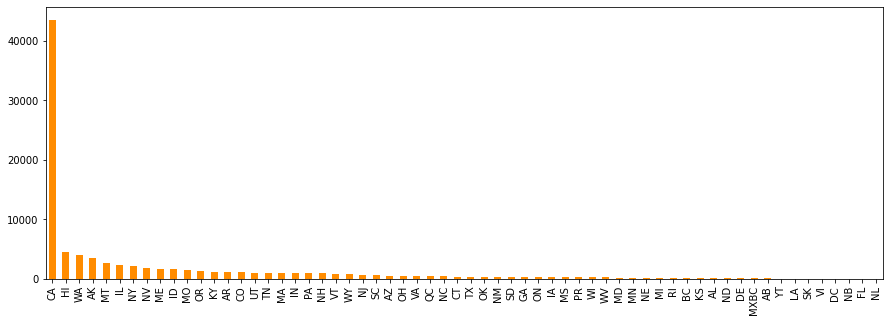

In [15]:
sismosdf['STATE'].value_counts().plot(kind='bar', figsize=(15,5), grid=False, color='darkorange')

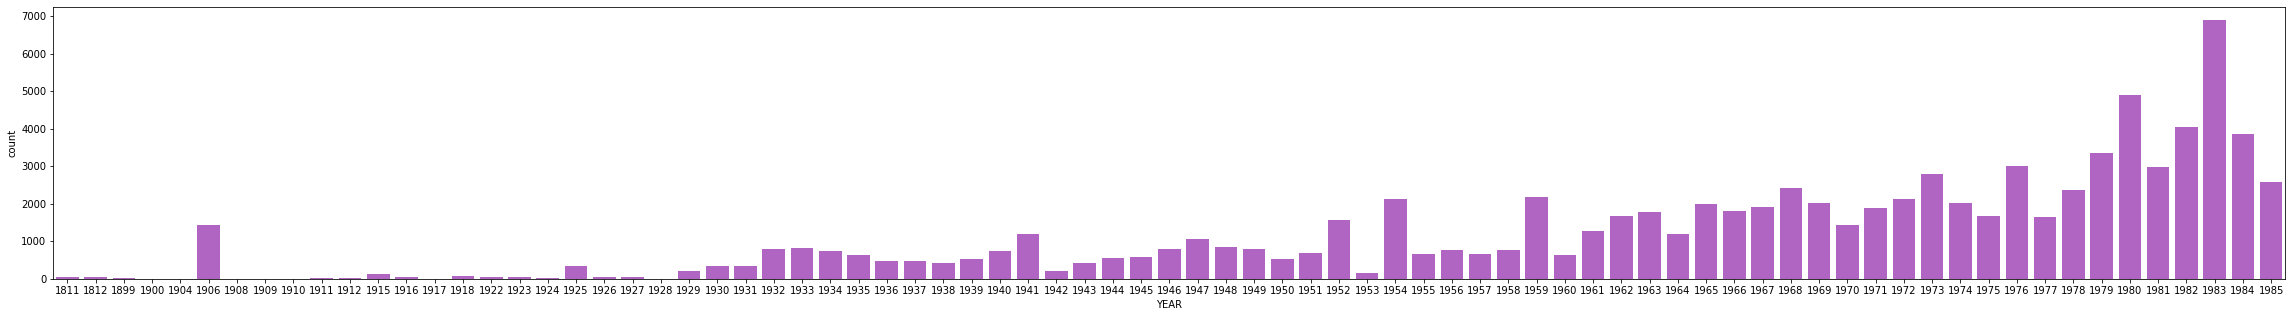

In [16]:
fig, ax = plt.subplots(figsize=(40,5))
sns.countplot(ax=ax, x=sismosdf['YEAR'], color='mediumorchid')
plt.show()

In [17]:
fig = go.Figure(data=go.Scattergeo(
        lon = sismosdf['CITY_LON'],
        lat = sismosdf['CITY_LAT'],
        text = sismosdf['MMI'],
        marker = dict(
        color = sismosdf['MMI'],
        colorscale = 'Rainbow',
        reversescale = True,
        opacity = 0.7,
        size = 5,
        colorbar = dict(
            titleside = "right",
            outlinecolor = "rgba(68, 68, 68, 0)",
            ticks = "outside",
            showticksuffix = "last",
            dtick = 1
        )
    )
        ))
fig.update_traces(marker=dict(size=15),
                  selector=dict(mode='markers'))
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=25),
    title = 'Intensidad de sismos',
    geo_scope='usa',
    )
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [18]:
sismosdf = sismosdf.set_index(['YEAR', 'MONTH'])
index_list = sismosdf.index.levels[0].tolist()
frames=[{
        'name': 'frame_{}'.format(i),

        'data': [{
            'type': 'scattermapbox',
            'lat': sismosdf.xs(i)['CITY_LAT'],
            'lon': sismosdf.xs(i)['CITY_LON'],
            'marker': go.scattermapbox.Marker(
                size=(sismosdf.xs(i)['MMI']-sismosdf.xs(i)['MMI'].mean()+3.5)**2 +sismosdf.xs(i)['MMI'],
                color=sismosdf.xs(i)['MMI'],
                showscale=True,
                colorscale='Jet',
                colorbar={'title': 'Intensidad', 'titleside': 'top', 'thickness': 4, 'ticksuffix': ' MMI'}
                ),
        'customdata': np.stack((
            sismosdf.xs(i)['MMI'],
            sismosdf.xs(i)['MAGNITUDE'],
            pd.Series(sismosdf.xs(i).index)),
                axis=-1
                ),
        'hovertemplate': "<extra></extra><em> Intensidad  %{customdata[0]}<br>Magnitud  %{customdata[1]}",
        }],
    } for i in index_list]

sliders = [{
            'transition':{'duration': 0},
            'x':0.08,
            'len':0.88,
            'currentvalue':{'font':{'size':15}, 'prefix':'Año ', 'visible':True, 'xanchor':'center'},
            'steps':[
                {
                    'label':i,
                    'method':'animate',
                    'args':[
                        ['frame_{}'.format(i)],
                        {'mode':'immediate', 'frame':{'duration':1000, 'redraw': True}, 'transition':{'duration':1000, }}
                      ],
                } for i in index_list]
        }]


# Primer cuadro
data = frames[0]['data']

# Añadiendo los sliders al layout
layout = go.Layout(
    sliders=sliders,
    margin=dict(l=0, r=0, b=0, t=25),
    title = 'Intensidad de sismos por año',
    mapbox={
        'accesstoken':'pk.eyJ1IjoiY2xhdWNvdCIsImEiOiJja2h4MTIxd2UwMzNzMnlvNzVycXN2dW14In0.J_KSzOY3YGDzozRdHvMJgQ',
        'center':{"lat": sismosdf['CITY_LAT'].mean(), "lon": sismosdf['CITY_LON'].mean()+10},
        'zoom':3,
        'style':'light',
    }
)
fig = go.Figure(data=data, layout=layout, frames=frames)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

## e) Escalamiento y Codificación de etiquetas

In [19]:
sismosdf = sismosdf[sismosdf.STATE == 'CA']
sismosdf.drop(['CITY','SOURCE','COUNTRY', 'DAY', 'HOUR','MINUTE','SECOND','STATE'], axis=1, inplace=True)

In [20]:
sismosdf.head()

MAGNITUDE  EPIDIST  CITY_LAT  CITY_LON  MMI
YEAR MONTH                                             
1948 12.0         4.0     47.0     33.22   -116.30  3.0
     12.0         4.0     52.0     33.02   -116.84  3.0
     12.0         4.0     84.0     32.77   -117.02  3.0
     12.0         4.0    156.0     34.18   -118.17  3.0
     12.0         6.0     28.0     39.80   -120.14  7.0

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sismos = scaler.fit_transform(sismosdf)

In [22]:
sismosdf.drop(['CITY_LAT','CITY_LON'], axis=1, inplace=True)

In [23]:
sismosdf.head()

MAGNITUDE  EPIDIST  MMI
YEAR MONTH                         
1948 12.0         4.0     47.0  3.0
     12.0         4.0     52.0  3.0
     12.0         4.0     84.0  3.0
     12.0         4.0    156.0  3.0
     12.0         6.0     28.0  7.0

In [38]:
sismosdf.shape

(43554, 4)

# Detección de Outliers

In [24]:
fig = px.scatter_3d(data_frame=sismosdf,
                    x='MAGNITUDE',
                    y='EPIDIST',
                    z='MMI',
                    color_continuous_scale=px.colors.sequential.Plasma,
                    template='seaborn',
                    title='Visualización de los datos',
                    width=1300,
                    height=500)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=25))
fig.update_traces(marker=dict(size=1),
                  selector=dict(mode='markers'))
pio.show(fig)

In [39]:
clf = LocalOutlierFactor(n_neighbors=800, contamination=0.1)
y_pred = clf.fit_predict(sismosdf)

In [40]:
pd.Series(y_pred)

0        1
1        1
2        1
3        1
4       -1
        ..
43549    1
43550    1
43551   -1
43552    1
43553    1
Length: 43554, dtype: int64

In [41]:
sismosdf['OUTLIER'] = y_pred
sismosdf.head()

MAGNITUDE  EPIDIST  MMI  OUTLIER
YEAR MONTH                                  
1948 12.0         4.0     47.0  3.0        1
     12.0         4.0     52.0  3.0        1
     12.0         4.0     84.0  3.0        1
     12.0         4.0    156.0  3.0        1
     12.0         6.0     28.0  7.0       -1

In [42]:
import plotly.express as px
import plotly.io as pio
import seaborn as sns

fig = px.scatter_3d(data_frame=sismosdf,
                    x='MAGNITUDE',
                    y='EPIDIST',
                    z='MMI',
                    color='OUTLIER',
                    color_continuous_scale=px.colors.sequential.Bluered,
                    template='seaborn',
                    title='Visualización de Outliers',
                    width=1300,
                    height=500)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=25))
fig.update_traces(marker=dict(size=1),
                  selector=dict(mode='markers'))
pio.show(fig)